In [1]:
import numpy as np
import cvxopt
import sklearn.datasets as ds
import matplotlib.pyplot as plt
from visualize import *

%matplotlib inline

In [2]:
class LinearSVM:
    def __init__(self, C):
        self.C = C
    
    def fit(self, X, y):
        l, n = X.shape
        
        P = cvxopt.matrix(np.diag([1] * n + [0] * (l+1)), tc='d')
        q = cvxopt.matrix(np.array([0] * (n+1) + [self.C] * l), tc='d')
        tmp = np.zeros((2*l, n+l+1))
        tmp[:l, n+1:] = -np.eye(l)
        tmp[l:, n+1:] = -np.eye(l)
        tmp[l:, :n] = -y[:,np.newaxis] * X
        tmp[l:, n] = -y
        G = cvxopt.matrix(tmp, tc='d')
        h = cvxopt.matrix(np.array([0] * l + [-1] * l), tc='d')
        
        self.w = np.array(cvxopt.solvers.qp(P, q, G, h)['x'][:n+1])
        
    def decision_function(self, X):
        return (X.dot(self.w[:-1])) + self.w[-1]
    
    def predict(self, X):
        return np.sign(self.decision_function(X)).T[0]

In [3]:
def linear_kernel(X1, X2):
    return X1.dot(X2.T)

In [4]:
def poly_kernel(X1, X2, degree=2):
    return np.power(X1.dot(X2.T) + 1, degree)

In [5]:
def gaussian_kernel(X1, X2, sigma=1.0):
    return np.exp(-sigma * np.square((X1[:, np.newaxis] - X2)).sum(axis=2))

In [6]:
class KernelSVM:
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        K = self.kernel(X, X)
        l, n = X.shape
        
        P = cvxopt.matrix(y[:,np.newaxis].dot(y[np.newaxis,:]) * K, tc='d')
        q = cvxopt.matrix(np.array([-1] * l), tc='d')
        tmp = np.zeros((2*l, l))
        tmp[:l] = np.eye(l)
        tmp[l:] = -np.eye(l)
        G = cvxopt.matrix(tmp, tc='d')
        h = cvxopt.matrix(np.array([self.C] * l + [0] * l), tc='d')
        A = cvxopt.matrix(y[np.newaxis, :], tc='d')
        b = cvxopt.matrix([0], tc='d')
        
        self.α = np.array(cvxopt.solvers.qp(P, q, G, h, A, b)['x'])
        
        self.w = 0
        num = 0
        ind = (self.α > 0).T[0]
        
        for x_, y_, k_ in zip(X[ind], y[ind], K[ind]):
            num += 1
            self.w += y_ - (self.α * y[:,np.newaxis] * k_[:,np.newaxis]).sum()
            
        self.w /= num
        self.X = X
        self.y = y
        
    def decision_function(self, X):
        ind = (self.α > 0).T[0]
        return self.kernel(X, self.X[ind]).dot(self.α[ind]*self.y[ind][:,np.newaxis]) + self.w
    
    def predict(self, X):
        return np.sign(self.decision_function(X)).T[0]

In [7]:
X, y = ds.make_blobs(centers=2, random_state=1)
y[y == 0] = -1

     pcost       dcost       gap    pres   dres
 0: -3.7363e+00  2.5074e+01  3e+02  2e+00  3e+02
 1:  1.6783e+01 -1.2352e+01  3e+01  1e-01  2e+01
 2:  2.0203e+00 -4.5730e-01  3e+00  5e-03  9e-01
 3:  8.7417e-02  5.2748e-03  8e-02  5e-05  8e-03
 4:  3.3230e-02  2.2155e-02  1e-02  4e-06  7e-04
 5:  3.4580e-02  2.6065e-02  9e-03  2e-06  4e-04
 6:  3.0434e-02  2.9915e-02  5e-04  1e-07  2e-05
 7:  3.0196e-02  3.0171e-02  2e-05  2e-09  3e-07
 8:  3.0185e-02  3.0184e-02  7e-07  4e-11  6e-09
 9:  3.0184e-02  3.0184e-02  8e-09  4e-13  6e-11
Optimal solution found.


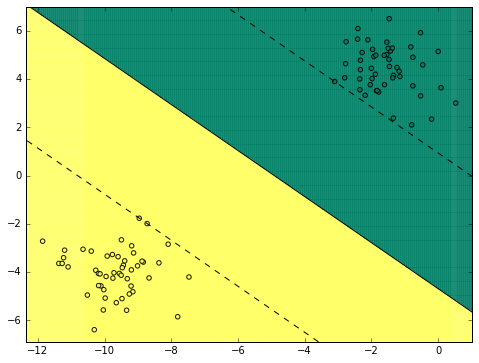

In [8]:
clf = LinearSVM(C=0.2)
clf.fit(X, y)
visualize(clf, X, y)

     pcost       dcost       gap    pres   dres
 0: -1.1957e+00 -2.4142e+01  3e+02  8e+00  2e-14
 1: -3.6420e-01 -1.8164e+01  3e+01  4e-01  3e-14
 2: -4.3512e-02 -2.0918e+00  3e+00  2e-02  5e-15
 3: -8.3372e-03 -8.8055e-02  8e-02  2e-04  2e-15
 4: -2.2270e-02 -3.3289e-02  1e-02  2e-05  6e-16
 5: -2.6125e-02 -3.4609e-02  9e-03  9e-06  5e-16
 6: -2.9918e-02 -3.0435e-02  5e-04  4e-07  5e-16
 7: -3.0171e-02 -3.0196e-02  2e-05  8e-09  9e-16
 8: -3.0184e-02 -3.0185e-02  7e-07  2e-10  8e-16
 9: -3.0184e-02 -3.0184e-02  8e-09  2e-12  8e-16
Optimal solution found.


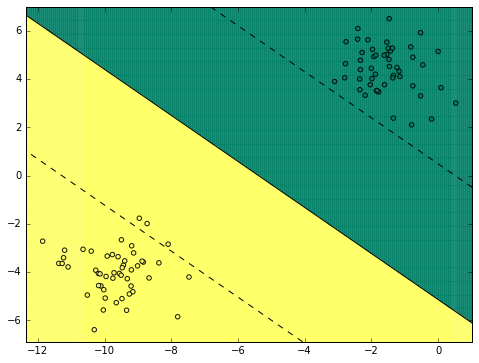

In [11]:
clf = KernelSVM(C=0.2, kernel=linear_kernel)
clf.fit(X, y)
visualize(clf, X, y)

     pcost       dcost       gap    pres   dres
 0: -1.1632e+00 -2.4000e+01  3e+02  8e+00  4e-12
 1: -3.5037e-01 -1.8009e+01  3e+01  4e-01  2e-12
 2: -6.6999e-02 -2.6945e+00  4e+00  4e-02  7e-13
 3: -1.2660e-02 -3.4162e-01  4e-01  4e-03  1e-13
 4: -8.2247e-04 -1.9034e-02  2e-02  2e-04  2e-14
 5: -1.6264e-04 -1.0225e-03  9e-04  2e-06  2e-15
 6: -3.1894e-04 -4.2784e-04  1e-04  2e-07  8e-16
 7: -3.3957e-04 -4.4082e-04  1e-04  1e-07  7e-16
 8: -3.7840e-04 -3.9350e-04  2e-05  1e-08  8e-16
 9: -3.8750e-04 -3.8807e-04  6e-07  7e-11  8e-16
10: -3.8791e-04 -3.8792e-04  2e-08  1e-12  1e-15
Optimal solution found.


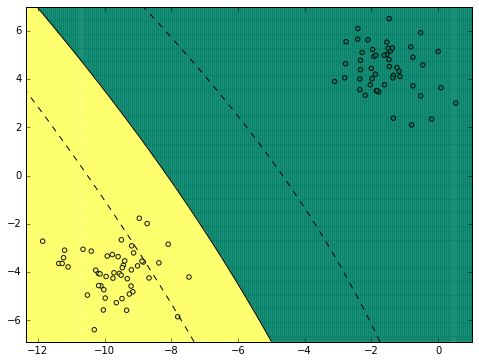

In [10]:
clf = KernelSVM(C=0.2, kernel=poly_kernel)
clf.fit(X, y)
visualize(clf, X, y)

     pcost       dcost       gap    pres   dres
 0: -6.4569e+00 -3.0287e+01  3e+02  8e+00  3e-16
 1: -5.3148e+00 -2.5930e+01  2e+01  1e-15  4e-16
 2: -5.6159e+00 -7.2224e+00  2e+00  3e-16  3e-16
 3: -5.9291e+00 -6.2399e+00  3e-01  4e-16  3e-16
 4: -5.9984e+00 -6.1105e+00  1e-01  2e-16  3e-16
 5: -6.0225e+00 -6.0568e+00  3e-02  2e-16  2e-16
 6: -6.0308e+00 -6.0460e+00  2e-02  2e-16  2e-16
 7: -6.0347e+00 -6.0377e+00  3e-03  3e-16  2e-16
 8: -6.0356e+00 -6.0361e+00  4e-04  2e-16  2e-16
 9: -6.0358e+00 -6.0358e+00  5e-05  2e-16  2e-16
10: -6.0358e+00 -6.0358e+00  8e-07  4e-16  2e-16
Optimal solution found.


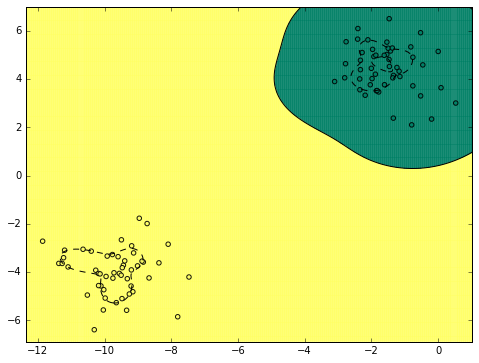

In [9]:
clf = KernelSVM(C=0.2, kernel=gaussian_kernel)
clf.fit(X, y)
visualize(clf, X, y)

In [12]:
X, y = ds.make_moons()
y[y == 0] = -1

     pcost       dcost       gap    pres   dres
 0: -8.7005e+00 -3.5566e+01  4e+02  1e+01  4e-16
 1: -6.2711e+00 -3.1043e+01  3e+01  2e-01  6e-16
 2: -6.1628e+00 -8.0773e+00  2e+00  5e-03  6e-16
 3: -6.4454e+00 -6.7814e+00  3e-01  7e-04  5e-16
 4: -6.5373e+00 -6.6692e+00  1e-01  2e-04  4e-16
 5: -6.5766e+00 -6.6160e+00  4e-02  6e-05  5e-16
 6: -6.5897e+00 -6.6022e+00  1e-02  2e-05  5e-16
 7: -6.5959e+00 -6.5969e+00  1e-03  3e-16  6e-16
 8: -6.5963e+00 -6.5963e+00  4e-05  2e-16  5e-16
 9: -6.5963e+00 -6.5963e+00  1e-06  2e-16  5e-16
Optimal solution found.


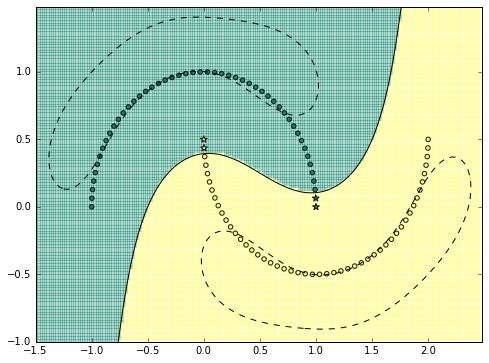

In [13]:
clf = KernelSVM(C=0.2, kernel=gaussian_kernel)
clf.fit(X, y)
visualize(clf, X, y)

In [14]:
X, y = ds.make_circles(factor=0.1)
y[y == 0] = -1

     pcost       dcost       gap    pres   dres
 0: -3.6078e+00 -2.3974e+01  2e+01  5e-16  6e-16
 1: -3.6149e+00 -3.9530e+00  3e-01  1e-16  6e-16
 2: -3.6162e+00 -3.6198e+00  4e-03  2e-16  5e-16
 3: -3.6162e+00 -3.6163e+00  4e-05  4e-16  5e-16
 4: -3.6162e+00 -3.6162e+00  4e-07  2e-16  4e-16
Optimal solution found.


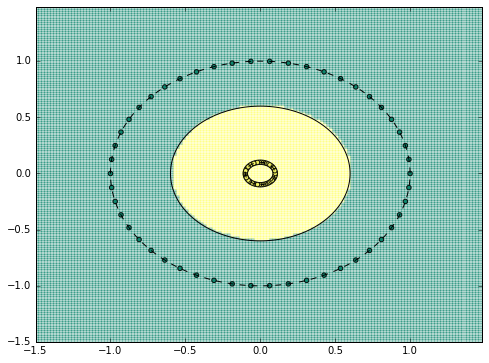

In [15]:
clf = KernelSVM(C=0.2, kernel=gaussian_kernel)
clf.fit(X, y)
visualize(clf, X, y)

In [16]:
X, y = ds.make_gaussian_quantiles(n_classes=2)
y[y == 0] = -1

     pcost       dcost       gap    pres   dres
 0: -1.2544e+01 -3.6147e+01  5e+02  1e+01  6e-16
 1: -6.6946e+00 -3.1922e+01  3e+01  1e-15  6e-16
 2: -7.3519e+00 -1.0208e+01  3e+00  5e-16  6e-16
 3: -8.1956e+00 -8.8698e+00  7e-01  2e-16  4e-16
 4: -8.4406e+00 -8.5672e+00  1e-01  6e-16  4e-16
 5: -8.4886e+00 -8.5081e+00  2e-02  4e-16  6e-16
 6: -8.4974e+00 -8.4984e+00  1e-03  3e-16  5e-16
 7: -8.4979e+00 -8.4980e+00  2e-05  2e-16  5e-16
 8: -8.4979e+00 -8.4979e+00  5e-07  3e-16  5e-16
Optimal solution found.


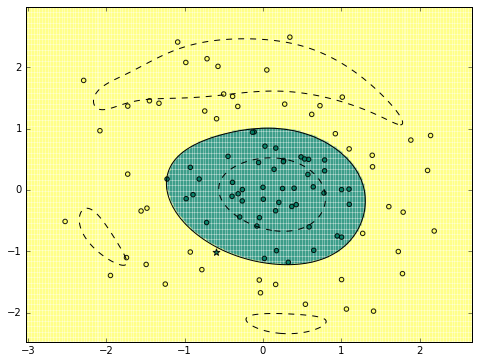

In [17]:
clf = KernelSVM(C=0.2, kernel=gaussian_kernel)
clf.fit(X, y)
visualize(clf, X, y)